# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
#Commom variables
samples = 20 # 20 samples per contamination level (from experiments)
cu_levels = [0,500,1000,2000,4000]      #Levels of Cu contamination
cr_levels = [0, 100, 500, 800, 1000]    #Levels of Cr contamination
features = int(22015)     #22015 wavelength features
wvl_in, wvl_end = 219, 877 #initial and final wavelength 

# Loading data

In [3]:
#Read data from Excel file
#Comment the lines depending on what metal is being analysed
#temp = pd.read_excel('copper.xlsx')    #Execution quite long
#metal_levels = cu_levels
temp = pd.read_excel('chromium.xlsx')    #Execution quite long
metal_levels = cr_levels

levels=len(metal_levels)

### Read the dataset:

In [4]:
data_numpy = temp.to_numpy()
metal = np.transpose(data_numpy)       #spreadsheet is comming in columms

wavelengths = metal[0,1:]   #save the wavelengths 
data=metal[1:,:]       #data is all the spreadsheet but the first row (wavelengths)

#### Divide data into training and test sets.

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=43)

#train_set, valid_set = train_test_split(train_full,test_size=10,random_state=43)

y_train = train_set[:,0]     # y_train is the first columm of train_set
y_test=test_set[:,0]       # y_test is the first columm of test_set
#y_valid=valid_set[:,0]       # y_valid is the first columm of valid_set

X_train=train_set[:,1:]    # X_train is all r,c of train_set but the first c
X_test=test_set[:,1:]      # X_test is all r,c of test_set but the first c
#X_valid=valid_set[:,1:]      # X_valid is all r,c of valid_set but the first c

### Build the model

In [6]:
from sklearn.ensemble import RandomForestClassifier
import time

forest_clf = RandomForestClassifier(random_state=623,max_depth=15)

start_1 = time.time()
forest_clf.fit(X_train, y_train) #Not saved?
end_1_st_6 = time.time()

#Compute the time differences for each subset
time_1 = end_1_st_6 - start_1
time_1

0.5171756744384766

#### Getting the cross validation confusion matrix 

In [7]:
from sklearn.model_selection import cross_val_predict

y_cv_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3) #no the definitive model

from sklearn.metrics import confusion_matrix
conf_mat_RF_cv = confusion_matrix(y_train, y_cv_pred)
conf_mat_RF_cv

array([[10,  2,  0,  0,  0],
       [ 0, 17,  0,  0,  0],
       [ 0,  0, 16,  2,  0],
       [ 0,  0,  2, 16,  0],
       [ 0,  0,  0,  0, 15]])

### Evaluations 

In [8]:
#Validate model with test set
from sklearn.metrics import accuracy_score

Acc_cv = accuracy_score(y_train, y_cv_pred)
print("The RF cross-validation accuracy score on train set is", Acc_cv)

The RF cross-validation accuracy score on train set is 0.925


### Model evaluation

In [9]:
# Test evaluation
y_test_pred = forest_clf.predict(X_test)

conf_mat_RF_test = confusion_matrix(y_test, y_test_pred)
conf_mat_RF_test

array([[8, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 5]])

In [10]:
Acc_test = accuracy_score(y_test, y_test_pred)
print("The RF accuracy score on test set is", Acc_test)


The RF accuracy score on test set is 0.9


## Data Augmentation

In [11]:
# Computing mean and std deviation of each feature for each contamination level 
ini=0
last=samples-1
meansT, stdT = np.zeros((features,levels)), np.zeros((features,levels))
for x in range(levels):
    sub_array=data[ini:last,1:]
    meansT[:,x]=sub_array.mean(axis=0)      #compute column means
    stdT[:,x]=sub_array.std(axis=0)      #compute column standard deviation
    ini=last+1
    last=last+samples
means = meansT.transpose()
std = stdT.transpose()
#print(means.shape)
#print(std.shape)

### Generating new data

In [12]:
Newsamples = 100   #Edit this number to have more samples per each level of contamination
last=Newsamples-1
ini = 0
newData=np.zeros((Newsamples*levels,features+1))  #Assuming 5 levels of contamination
for x in range(levels):
    newData[ini:last+1,0]= np.tile(metal_levels[x],Newsamples)
    newData[ini:last+1,1:] = np.random.normal(means[x,:],std[x,:],size=(Newsamples,features))
    ini=ini+Newsamples
    last=last+Newsamples    
#newData.shape

### Testing the new Data Set

In [13]:
#Separate X and y fromm datasets

y_newData = newData[:,0]     # y is the first columm of the set
y_data = data[:,0]      

X_newData = newData[:,1:]    # X is all r,c of the set but the first c
X_data = data[:,1:]

In [14]:
#Fit the model
start_1 = time.time()
forest_clf.fit(X_newData, y_newData) 
end_1_st_6 = time.time()

#Compute the time differences for each subset
time_1 = end_1_st_6 - start_1
print(time_1)

#Execute a cross validation
#y_cv_nD_pred = cross_val_predict(forest_clf, X_newData, y_newData, cv=3) #no the definitive model

#from sklearn.metrics import confusion_matrix
#conf_mat_RF_nD = confusion_matrix(y_newData, y_cv_nD_pred)
#conf_mat_RF_nD

2.6685760021209717


In [15]:
# Real data evaluation model

y_data_pred = forest_clf.predict(X_data)

#from sklearn.metrics import confusion_matrix
conf_mat_RF_data = confusion_matrix(y_data, y_data_pred)
conf_mat_RF_data

array([[20,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0, 19,  1,  0],
       [ 0,  0,  3, 17,  0],
       [ 0,  0,  0,  0, 20]])

In [16]:
Acc_data = accuracy_score(y_data, y_data_pred)
print("The RF accuracy score on real data set is", Acc_data)

The RF accuracy score on real data set is 0.96


Text(0, 0.5, 'wavelength')

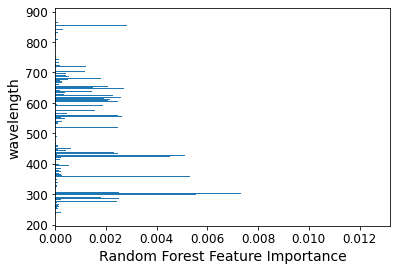

In [17]:
sorted_idx = forest_clf.feature_importances_.argsort()[::-1]

plt.barh(wavelengths[sorted_idx], forest_clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("wavelength")

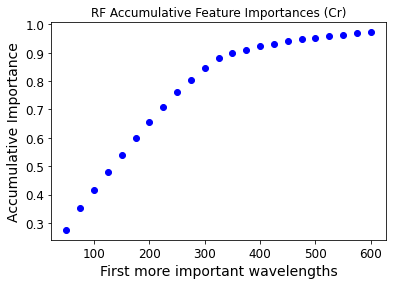

In [39]:
features = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600]
importance = []
for x in features:
    temp = sorted_idx[0:x]
    importance.append(sum(forest_clf.feature_importances_[temp]))

# plot predicted data
plt.scatter(features, importance, 
         color = 'blue') 
plt.title('RF Accumulative Feature Importances (Cr)')
plt.xlabel('First more important wavelengths')
plt.ylabel('Accumulative Importance')
plt.show()

In [32]:
#sorted_idx[0:features[12]]
importance.shape

(13,)

In [20]:
wavelengths[sorted_idx[0:49]]

array([298.62442, 297.55746, 425.38177, 425.3559 , 520.74908, 302.19446,
       301.48096, 428.96533, 520.33533, 298.64255, 492.22037, 635.5415 ,
       357.89059, 520.8446 , 359.36469, 301.53577, 357.93387, 360.5397 ,
       284.34619, 357.84732, 427.48138, 540.97284, 359.40814, 625.10181,
       301.49921, 526.54443, 520.43079, 303.44232, 313.22299, 529.77429,
       434.47879, 267.73178, 435.21945, 425.51105, 611.97968, 526.51227,
       301.38959, 435.19296, 360.45251, 526.41565, 286.53687, 300.51379,
       285.00528, 434.45236, 603.80103, 425.40762, 423.88492, 541.00592,
       492.16025])

## Regression model

In [21]:
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 623)
  
# fit the regressor with x and y data
regressor.fit(X_newData, y_newData)

RandomForestRegressor(random_state=623)

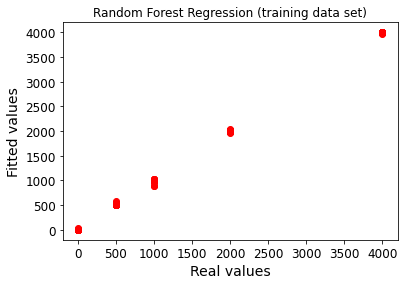

In [20]:
#Fitted values
y_rg_newData = regressor.predict(X_newData)

# plot predicted data
plt.scatter(y_newData, y_rg_newData, 
         color = 'red') 
plt.title('Random Forest Regression (training data set)')
plt.xlabel('Real values')
plt.ylabel('Fitted values')
plt.show()

In [22]:
from sklearn.metrics import r2_score

### y_data is the actual value and y_rg_data is the predicted values
r2 = r2_score(y_newData, y_rg_newData)
print('r2 score for test data set is', r2)

r2 score for test data set is 0.99993025


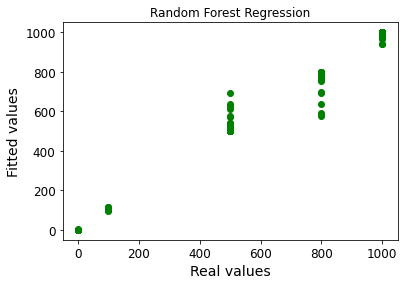

In [23]:
#Fitted values
y_rg_data = regressor.predict(X_data)

# plot predicted data
plt.scatter(y_data, y_rg_data, 
         color = 'green') 
plt.title('Random Forest Regression')
plt.xlabel('Real values')
plt.ylabel('Fitted values')
plt.show()

In [24]:
from sklearn.metrics import r2_score

### y_data is the actual value and y_rg_data is the predicted values
r2 = r2_score(y_data, y_rg_data)
print('r2 score for perfect model is', r2)

r2 score for perfect model is 0.9826695187165775
